In [1]:
%matplotlib inline

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Simulate Data

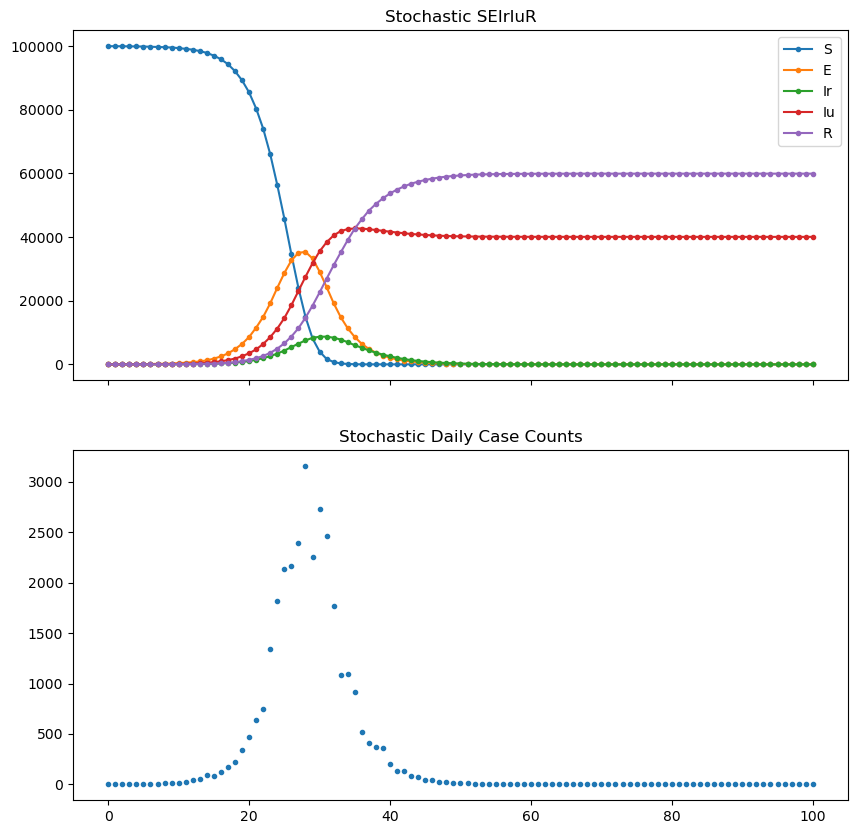

In [16]:
import importlib
import sys
import os

import seir
importlib.reload(seir)

true_params = {
    'beta': 2.1,
    'mu': 0.5,
    'Z': 4,
    'D': 4.,
    'alpha': 0.3,
    'n_t': 100,
    'N': 100_000.,
    'E0': 0.,
    'Iu0': 10.,
}

np.random.seed(1994)
data = seir.simualte_data(**true_params, add_noise=True, noise_param=1/50)
data.plot_all()

In [101]:
data.i

array([0.00000000e+00, 0.00000000e+00, 2.86787794e+00, 2.49191741e+00,
       2.75672234e+00, 8.19591804e+00, 5.31396781e+00, 7.96063545e+00,
       1.13001332e+01, 1.37042079e+01, 1.66458598e+01, 2.57683596e+01,
       4.29321756e+01, 5.36177436e+01, 9.50471175e+01, 8.76009765e+01,
       1.17766679e+02, 1.71355271e+02, 2.22723941e+02, 3.43071785e+02,
       4.65700940e+02, 6.35495363e+02, 7.42397854e+02, 1.33867479e+03,
       1.81953010e+03, 2.13481057e+03, 2.16550297e+03, 2.39580270e+03,
       3.15493302e+03, 2.25123625e+03, 2.72793609e+03, 2.46101767e+03,
       1.77012627e+03, 1.08414833e+03, 1.09663879e+03, 9.15397404e+02,
       5.17647619e+02, 4.11110299e+02, 3.74156418e+02, 3.60298698e+02,
       1.97491038e+02, 1.36717678e+02, 1.32124688e+02, 7.89872768e+01,
       7.13748484e+01, 4.43601311e+01, 4.23653417e+01, 2.37463235e+01,
       2.11303668e+01, 1.57774484e+01, 9.78248027e+00, 1.14953597e+01,
       7.85999394e+00, 7.07920861e+00, 1.55862012e+00, 2.35839084e+00,
      

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import inspect
import logging


class seir_metapop():
    def __init__(
            self, n_t, n_loc, beta, mu, Z, D, alpha, N, E0, Iu0, **kwargs
            ):
        r"""
        Args:
          n_t (int): number of days
          n_loc (int): number of locations
          beta (list): transmission rates
          mu (float): relative transmission rate of unreported
          Z (float): avg latency period
          D (float): avg infectious period
          alpha (float): reporting proportion
          N (int): Population
          E0 (int): Iniital number of exposed
          Iu0 (int): Intitial number of unreported infectors
        """
        self.n_t = n_t
        self.n_loc = n_loc

        self.beta = beta
        if len(beta) != n_loc:
            raise Exception(f"there should be {n_loc} beta")
        self.mu = mu
        self.Z = Z
        self.D = D
        self.alpha = alpha

        self.N = N
        self.S0 = (N - E0 - Iu0) * np.ones((n_loc, n_loc))
        self.E0 = E0 * np.ones((n_loc, n_loc))
        self.Ir0 = np.zeros((n_loc, n_loc))
        self.Iu0 = Iu0 * np.ones((n_loc, n_loc))
        self.R0 = np.zeros((n_loc, n_loc))

        self.S, self.E, self.Ir, self.Iu, self.R, \
            self.i, self.i_true = self.gen_stoch_seir_metapop()

    def gen_stoch_seir_metapop(
            self, add_noise=False, noise_param=1/25
            ):
        import pdb; pdb.set_trace()
        S = np.sum(self.S0, axis=1)
        E = np.sum(self.E0, axis=1)
        Ir = np.sum(self.Ir0, axis=1)
        Iu = np.sum(self.Iu0, axis=1)
        R = np.sum(self.R0, axis=1)
        S_list = [S]
        E_list = [E]
        Ir_list = [Ir]
        Iu_list = [Iu]
        R_list = [R]
        i_true = []
        i_list = []

        # Time
        dt_day = 1 / 3

        # Generate tspan
        tspan = np.zeros(2 * self.n_t+1)
        for i in range(self.n_t):
            tspan[2*i] = i
            tspan[2*i+1] = i + dt_day
        tspan[-1] = self.n_t

        for t in tspan:
            if t % 1 == 0:  # daytime
                daytime_i = np.zeros(self.n_loc)
                daytime_i = np.zeros(self.n_loc)
                # Loop over destination
                for i in range(self.n_loc):
                    # Day time population
                    N_i = np.sum(self.N[i, :]) + np.sum(Ir[:, i]) - np.sum(Ir[i, :])

                    # Loop over origin
                    for j in range(self.n_loc):
                        dSE = np.random.poisson(self.beta[i]*S[i, j]*(np.sum(Ir[:, i])+self.mu*np.sum(Iu[i, :]))/N_i)
                        dEI = np.random.poisson(E[i, j]/self.Z)
                        dIrR = np.random.poisson(Ir[i, j]/self.D)
                        dIuR = np.random.poisson(Iu[i, j]/self.D)

                        S = np.clip(S-dSE, 0, np.sum(self.N[i,:]))
                        E = np.clip(E+dSE-dEI, 0, np.sum(self.N[i,:]))
                        Ir = np.clip(Ir+dEI*self.alpha-dIrR, 0, np.sum(self.N[i,:]))
                        Iu = np.clip(Iu+dEI*(1-self.alpha)-dIuR, 0, np.sum(self.N[i,:]))
                        R = np.clip(R+dIrR+dIuR, 0, np.sum(self.N[i,:]))
                        
                        daytime_i[i] += dEI*self.alpha

            else:  # nighttime
                nighttime_i = np.zeros(self.n_loc)
                # loop over destination
                for i in range(self.n_loc):
                    # loop over origin
                    for j in range(self.n_loc):
                        # night time population
                        N_j = np.sum(self.N[:, j])
                        dSE = np.random.poisson(self.beta[i]*S[i, j]*(np.sum(Ir[:, i])+self.mu*np.sum(Iu[i, :]))/N_j)
                        dEI = np.random.poisson(E[i, j]/self.Z)
                        dIrR = np.random.poisson(Ir[i, j]/self.D)
                        dIuR = np.random.poisson(Iu[i, j]/self.D)

                        S = np.clip(S-dSE, 0, np.sum(self.N[i,:]))
                        E = np.clip(E+dSE-dEI, 0, np.sum(self.N[i,:]))
                        Ir = np.clip(Ir+dEI*self.alpha-dIrR, 0, np.sum(self.N[i,:]))
                        Iu = np.clip(Iu+dEI*(1-self.alpha)-dIuR, 0, np.sum(self.N[i,:]))
                        R = np.clip(R+dIrR+dIuR, 0, self.N)

                        nighttime_i[i] += dEI*self.alpha
                
                S_list = S_list.append(np.sum(S,axis=1))
                E_list = E_list.append(np.sum(E,axis=1))
                Ir_list = Ir_list.append(np.sum(Ir,axis=1))
                Iu_list = Iu_list.append(np.sum(Iu,axis=1))
                R_list = R_list.append(np.sum(R,axis=1))
                i_true = i_true.append(daytime_i + nighttime_i)

            if add_noise:
                self.noise_param = noise_param
                obs_error_var = np.maximum(1., np.array(i_true)**2 * noise_param)
                obs_error_sample = np.random.normal(0, 1, size=self.n_t)
                i_true += obs_error_sample * np.sqrt(obs_error_var)
                i_list = np.clip(i_true, 0, self.N)

        return S_list, E_list, Ir_list, Iu_list, R_list, i_true, i_list

In [ ]:
true_params = {
    'beta': [2.1, 3, 4, 5, 1, 3, 5, 6, 1, 3, 5, 6, 7, 3, 1, 3, 5],
    'mu': 0.5,
    'Z': 4,
    'D': 4.,
    'alpha': 0.3,
    'n_t': 100,
    'n_loc': 17,
    'N': N,
    'E0': 0.,
    'Iu0': 10.,
}

np.random.seed(1994)
data = seir_metapop(**true_params, add_noise=True, noise_param=1/50)

> /var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_10381/3227685200.py(50)gen_stoch_seir_metapop()
     48             ):
     49         import pdb; pdb.set_trace()
---> 50         S = np.sum(self.S0, axis=1)
     51         E = np.sum(self.E0, axis=1)
     52         Ir = np.sum(self.Ir0, axis=1)



ipdb>  n


> /var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_10381/3227685200.py(51)gen_stoch_seir_metapop()
     49         import pdb; pdb.set_trace()
     50         S = np.sum(self.S0, axis=1)
---> 51         E = np.sum(self.E0, axis=1)
     52         Ir = np.sum(self.Ir0, axis=1)
     53         Iu = np.sum(self.Iu0, axis=1)

